%reload_ext autoreload
%autoreload 2

In [26]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
import math
# from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
# from mappings import *
from train_functions import *
from random import shuffle
import gc

torch.cuda.empty_cache() # PyTorch thing
gc.collect()

2.0.1


2588

In [39]:
import sys
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

In [40]:
def print_obj_API(obj):
    attributes = [attr for attr in dir(obj) if not attr.startswith('__')]

    # Differentiating between methods and attributes
    methods = [attr for attr in attributes if callable(getattr(obj, attr)) and not attr.startswith('_')]
    attributes = [attr for attr in attributes if not callable(getattr(obj, attr)) and not attr.startswith('_')]
    
    print(f"{type(obj).__name__} Attributes:", attributes)
    print("\n")
    print(f"{type(obj).__name__} Methods:", methods)

In [41]:
#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

#! --- GET WEIGHTS ---
nweights = {
    'C':    1000.03805769363678407,
    'Br':   16.347081228646626,
    'N':    1.2521717662942678,
    'O':    1.2571374939894111,
    'S':    1.9962749509415432,
    'Cl':   3.4266994716029413,
    'F':    2.004610604390097,
    'P':    46.948356807511736,
    'I':    122.63919548687761,
    'B':    469.4835680751174,
    'Si':   519.2107995846313,
    'Se':   713.26676176890164
}


bweights = {
    BT.SINGLE:  1.5474413794296493,
    BT.AROMATIC:  1.561455769468956,
    BT.DOUBLE:  4.079857498737284,
    BT.TRIPLE:  117.53505483010308
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 500.)
node_weights = torch.tensor(nweights_list, device=device, dtype=torch.float32)
edge_weights = torch.tensor(bweights_list, device=device, dtype=torch.float32)


[18:27:29] WARNING: no name column found on line 0
[18:27:29] WARNING: no name column found on line 1
[18:27:29] WARNING: no name column found on line 2
[18:27:29] WARNING: no name column found on line 3
[18:27:29] WARNING: no name column found on line 4
[18:27:29] WARNING: no name column found on line 5
[18:27:29] WARNING: no name column found on line 6
[18:27:29] WARNING: no name column found on line 7
[18:27:29] WARNING: no name column found on line 8
[18:27:29] WARNING: no name column found on line 9
[18:27:29] WARNING: no name column found on line 10
[18:27:29] WARNING: no name column found on line 11
[18:27:29] WARNING: no name column found on line 12
[18:27:29] WARNING: no name column found on line 13
[18:27:29] WARNING: no name column found on line 14
[18:27:29] WARNING: no name column found on line 15
[18:27:29] WARNING: no name column found on line 16
[18:27:29] WARNING: no name column found on line 17
[18:27:29] WARNING: no name column found on line 18
[18:27:29] WARNING: no

In [42]:
def get_random_batch(data = train_guac_mols, bs=32):
    shuffle(train_guac_mols)
    return rdkit2pyg(train_guac_mols[:bs])

In [43]:
LR = 6e-6
bs = 32
wd = 10e-6

In [44]:
#! --- SET UP EXPERIMENT ---
epoch, max_epoch = 1, 100
train_data = get_random_batch(bs=32)
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()

for m in [rnn, output]:
    m.apply(weight_init)
    m.ad_hoc_init()

optimizer = torch.optim.RMSprop(list(rnn.parameters()) + list(output.parameters()), lr=LR, weight_decay=wd, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

In [45]:
grads_dict = {}
for name, module in rnn.named_modules():
    for pname, p in module.named_parameters():
        if ".weight" in pname:
            grads_dict[pname] = []

grads_dict_out = {}
for name, module in output.named_modules():
    for pname, p in module.named_parameters():
        if ".weight" in pname:
            grads_dict_out[pname] = []


@torch.no_grad()
def get_grads():
    for name, module in rnn.named_modules():
        for pname, p in module.named_parameters():
            if ".weight" in pname:
                grads_dict[pname].append(p.grad.detach().cpu())

    for name, module in output.named_modules():
        for pname, p in module.named_parameters():
            if ".weight" in pname:
                grads_dict_out[pname].append(p.grad.detach().cpu())

In [46]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_output_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    elif isinstance(module, nn.LeakyReLU):
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []

layer_means_output = {}
layer_stds_output = {}
layer_hists_output = {}
for idx, (name, module) in enumerate(output.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_output[f'{name}_output_{idx}'] = []
            layer_means_output[f'{name}_hidden_{idx}'] = []
            layer_stds_output[f'{name}_output_{idx}'] = []
            layer_stds_output[f'{name}_hidden_{idx}'] = []
            layer_hists_output[f'{name}_output_{idx}'] = []
            layer_hists_output[f'{name}_hidden_{idx}'] = []
    elif isinstance(module, nn.LeakyReLU):
        layer_means_output[name] = []
        layer_stds_output[name] = []
        layer_hists_output[name] = []

In [47]:
def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    elif isinstance(module, nn.LeakyReLU):
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

def append_out(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_output[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_output[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_output[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_output[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_output[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_output[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    elif isinstance(module, nn.LeakyReLU):
        layer_means_output[name].append(output.detach().cpu().numpy().mean())
        layer_stds_output[name].append(output.detach().cpu().numpy().std())
        layer_hists_output[name].append(output.detach().cpu().abs().histc(40,0,10))

In [48]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

for idx, (module_name, module) in enumerate(output.named_children()):
    module.register_forward_hook(partial(append_out, idx, module_name))

In [49]:
class gpu_mem_restore_ctx():
    " context manager to reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    def __enter__(self): return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if not exc_val: return True
        traceback.clear_frames(exc_tb)
        raise exc_type(exc_val).with_traceback(exc_tb) from None

In [50]:
with gpu_mem_restore_ctx():
    epoch = 0
    update = []
    update_output = []
    while epoch < max_epoch:
        rnn.train()
        output.train()
        loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
        for batch_idx, data in enumerate(train_dataset_loader):
            rnn.zero_grad()
            output.zero_grad()
            loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
            loss.backward()
            get_grads()
            if scheduler != None: 
                current_lr = scheduler.get_last_lr()[0]
            else:
                current_lr = optimizer.param_groups[0]['lr'][0]
            
            with torch.no_grad():
                update.append([(current_lr* p.grad.std()/p.data.std()).log10().item() for p in rnn.parameters()])
                update_output.append([(current_lr* p.grad.std()/p.data.std()).log10().item() for p in rnn.parameters()])
            
            # nn.utils.clip_grad_value_(list(output.parameters()), clip_value=.25) # try .5,  0.25)

            optimizer.step()        
            if scheduler != None: scheduler.step()
            loss_sum_edges += edge_loss.item()
            loss_sum_nodes += node_loss.item()
            loss_all =  loss_sum_edges + loss_sum_nodes
            print(f"Epoch {epoch}, ", loss_all / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
        epoch +=1



Epoch 0,  2213.4373779296875 lossedges 422.5369873046875  lossnodes  1790.900390625
Epoch 1,  2210.407470703125 lossedges 421.9267578125  lossnodes  1788.480712890625
Epoch 2,  2205.0288696289062 lossedges 420.84710693359375  lossnodes  1784.1817626953125
Epoch 3,  2196.6673278808594 lossedges 419.1757507324219  lossnodes  1777.4915771484375
Epoch 4,  2184.080047607422 lossedges 416.6777038574219  lossnodes  1767.40234375
Epoch 5,  2165.6754455566406 lossedges 413.0655822753906  lossnodes  1752.60986328125
Epoch 6,  2139.635223388672 lossedges 408.0574645996094  lossnodes  1731.5777587890625
Epoch 7,  2103.96533203125 lossedges 401.4091796875  lossnodes  1702.55615234375
Epoch 8,  2056.2608642578125 lossedges 392.86962890625  lossnodes  1663.3912353515625
Epoch 9,  1993.6693725585938 lossedges 382.29388427734375  lossnodes  1611.37548828125
Epoch 10,  1912.6922607421875 lossedges 369.71923828125  lossnodes  1542.9730224609375
Epoch 11,  1809.0390319824219 lossedges 355.2218933105469  l

# MEMORIZATION

In [51]:
# obs = train_guac_mols[5]
# print(Chem.MolToSmiles(obs))
# train_data = rdkit2pyg([obs])

# train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
# max_epoch = 10000
# params = list(rnn.parameters()) + list(output.parameters())
# optimizer = torch.optim.RMSprop(params, lr=1e-5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
# memorize_batch_single_opt(max_epoch, rnn, output, train_dataset_loader, optimizer, node_weights, edge_weights, scheduler)

# Activations analysis

## Activations

Text(0.5, 1.0, 'MEANS node lvl rnn')

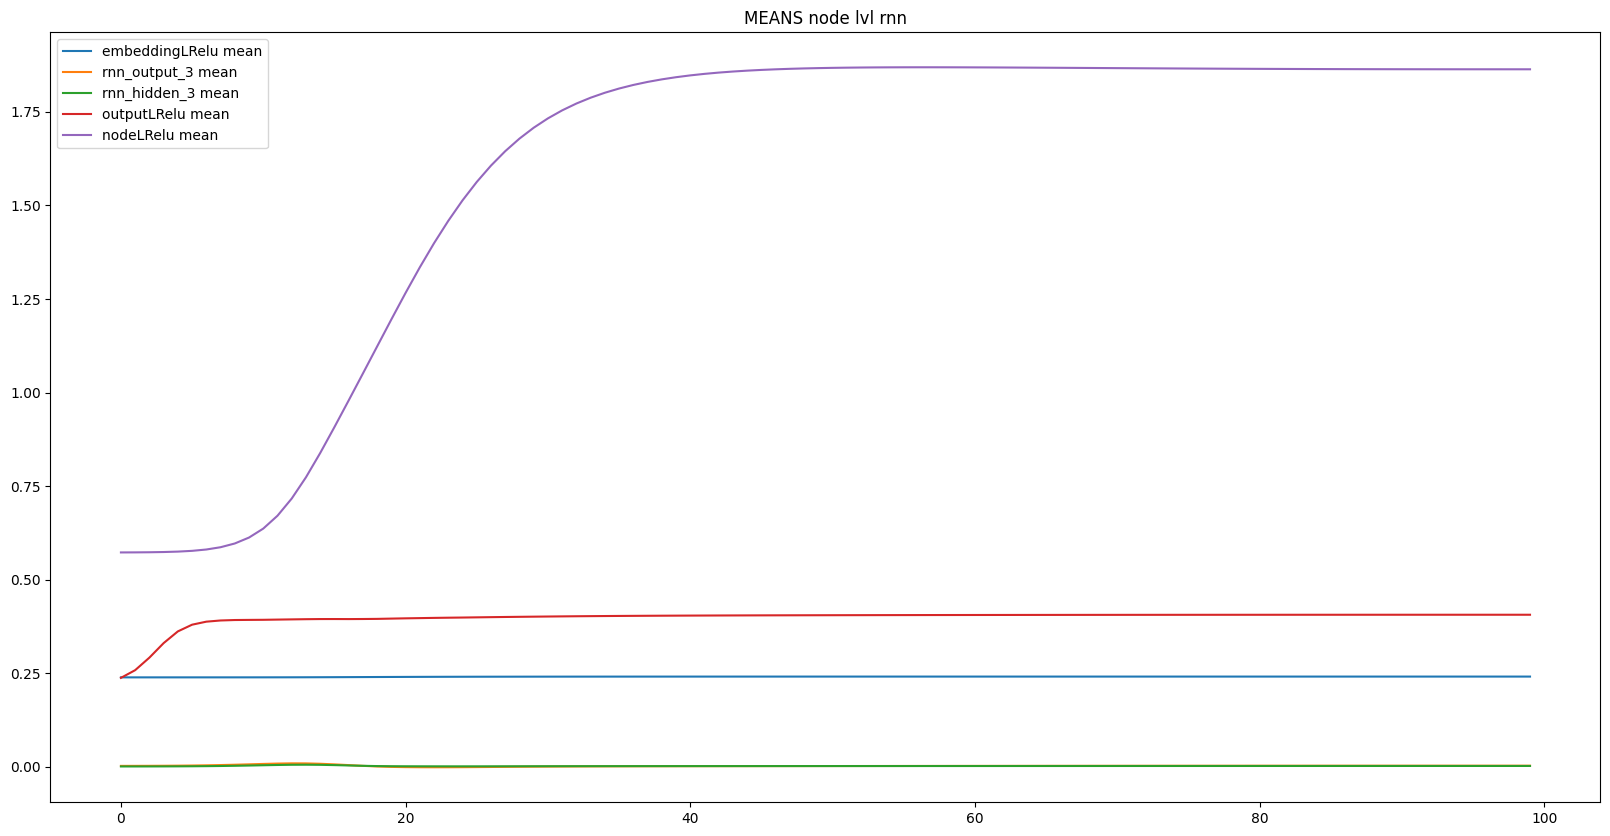

In [63]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("MEANS node lvl rnn")

Text(0.5, 1.0, 'MEANS edge lvl rnn')

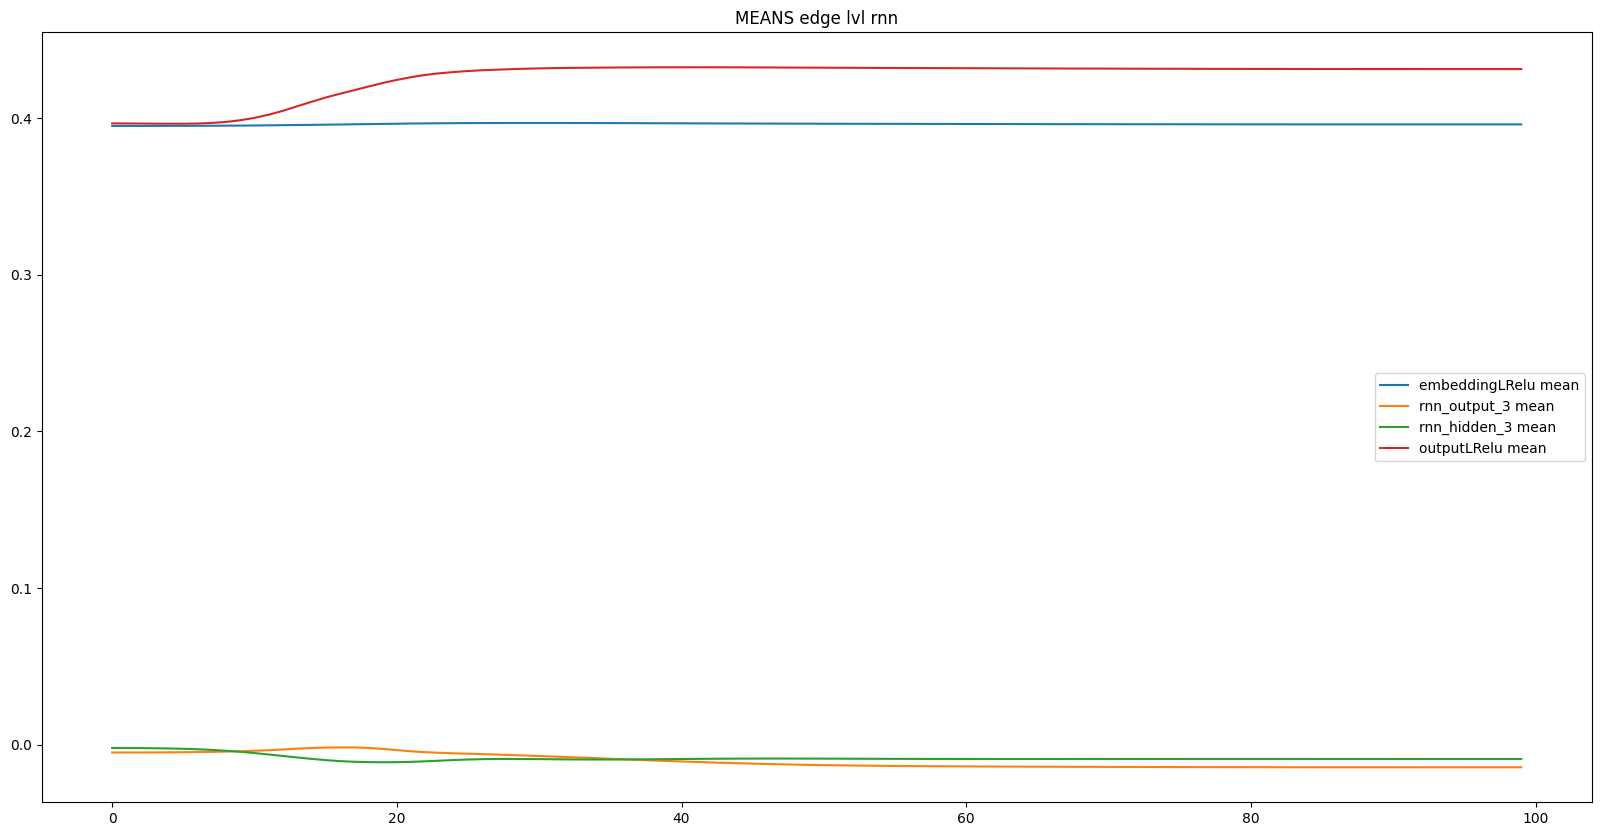

In [64]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_means_output.keys()):
    plt.plot([i for i in range(len(layer_means_output[k]))], layer_means_output[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("MEANS edge lvl rnn")

Text(0.5, 1.0, 'STDS node RNN')

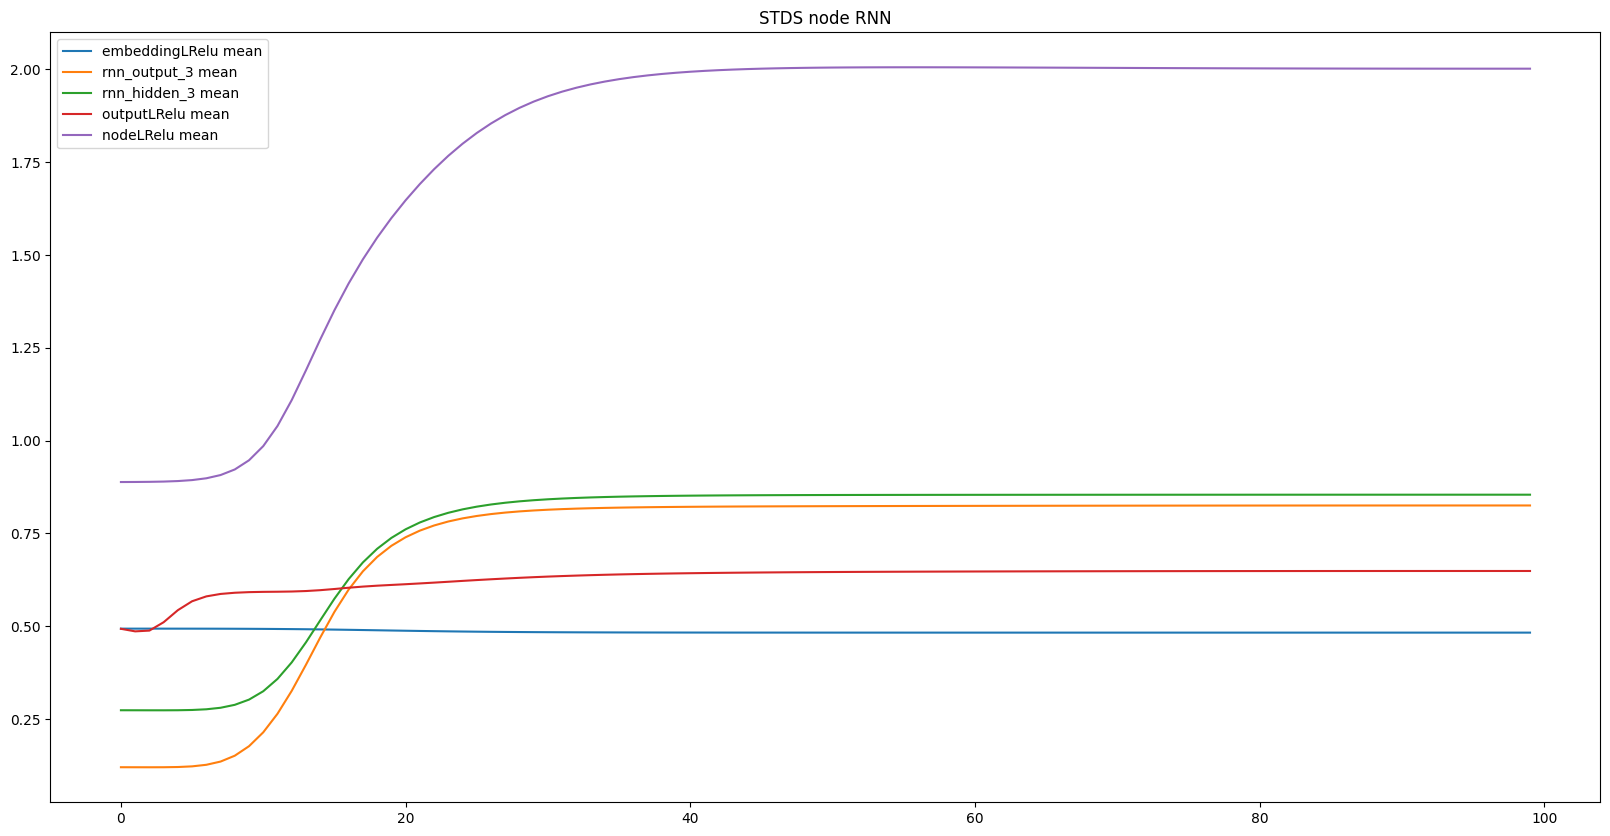

In [65]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("STDS node RNN")

Text(0.5, 1.0, 'STDS edge RNN')

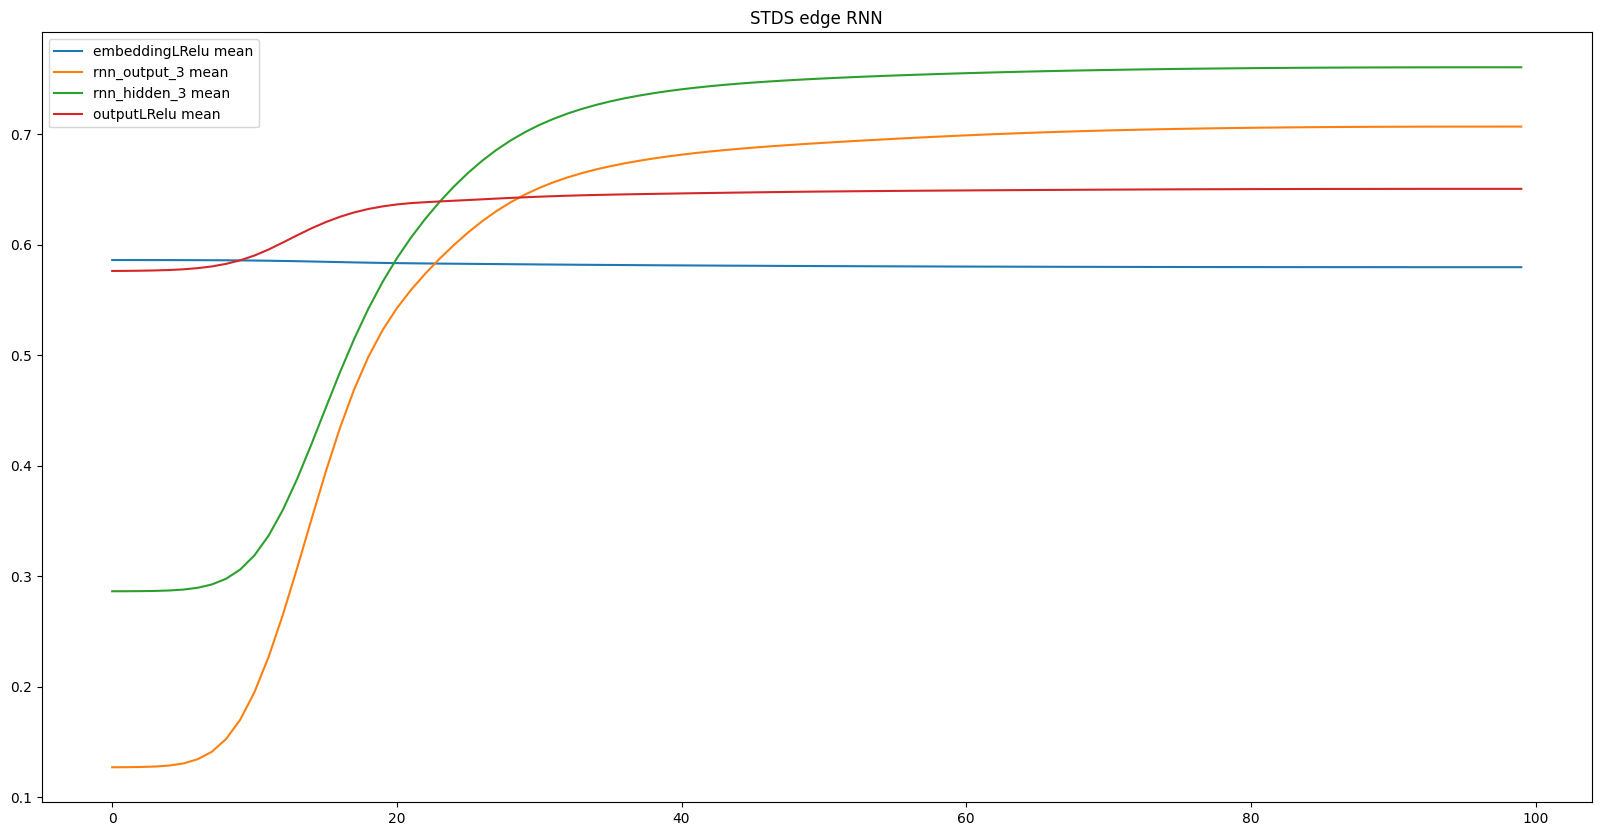

In [66]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_stds_output.keys()):
    plt.plot([i for i in range(len(layer_stds_output[k]))], layer_stds_output[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("STDS edge RNN")

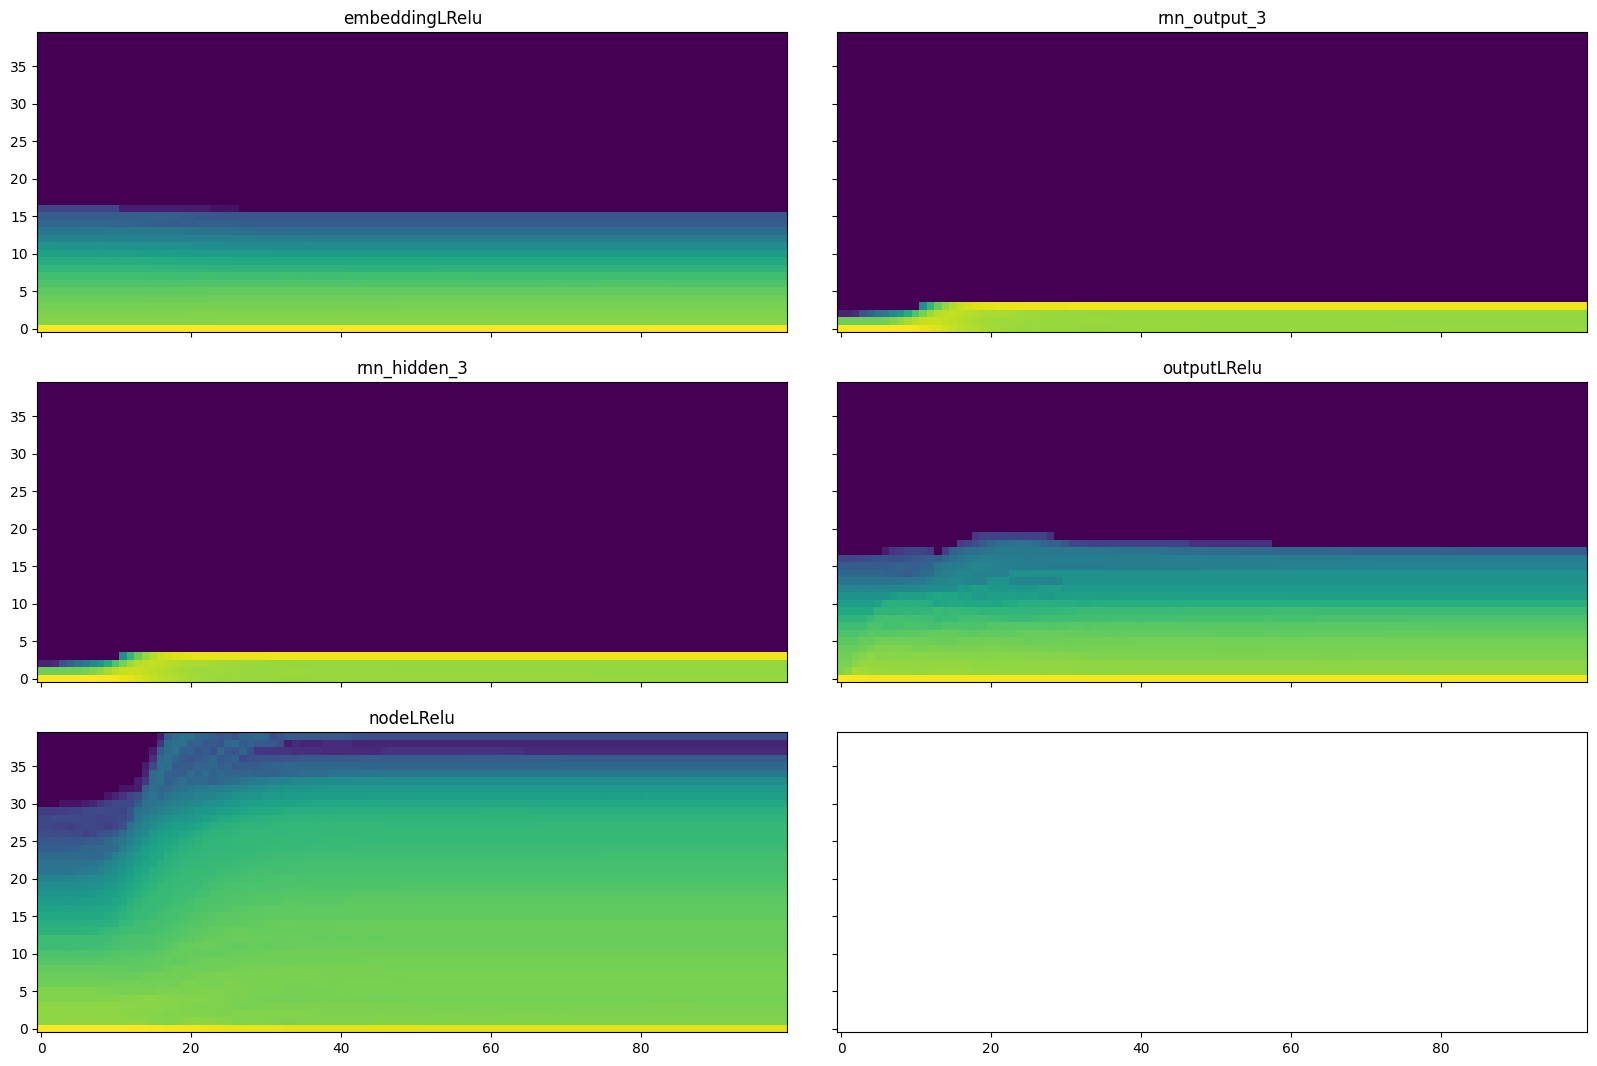

In [67]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_rnn.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_rnn[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

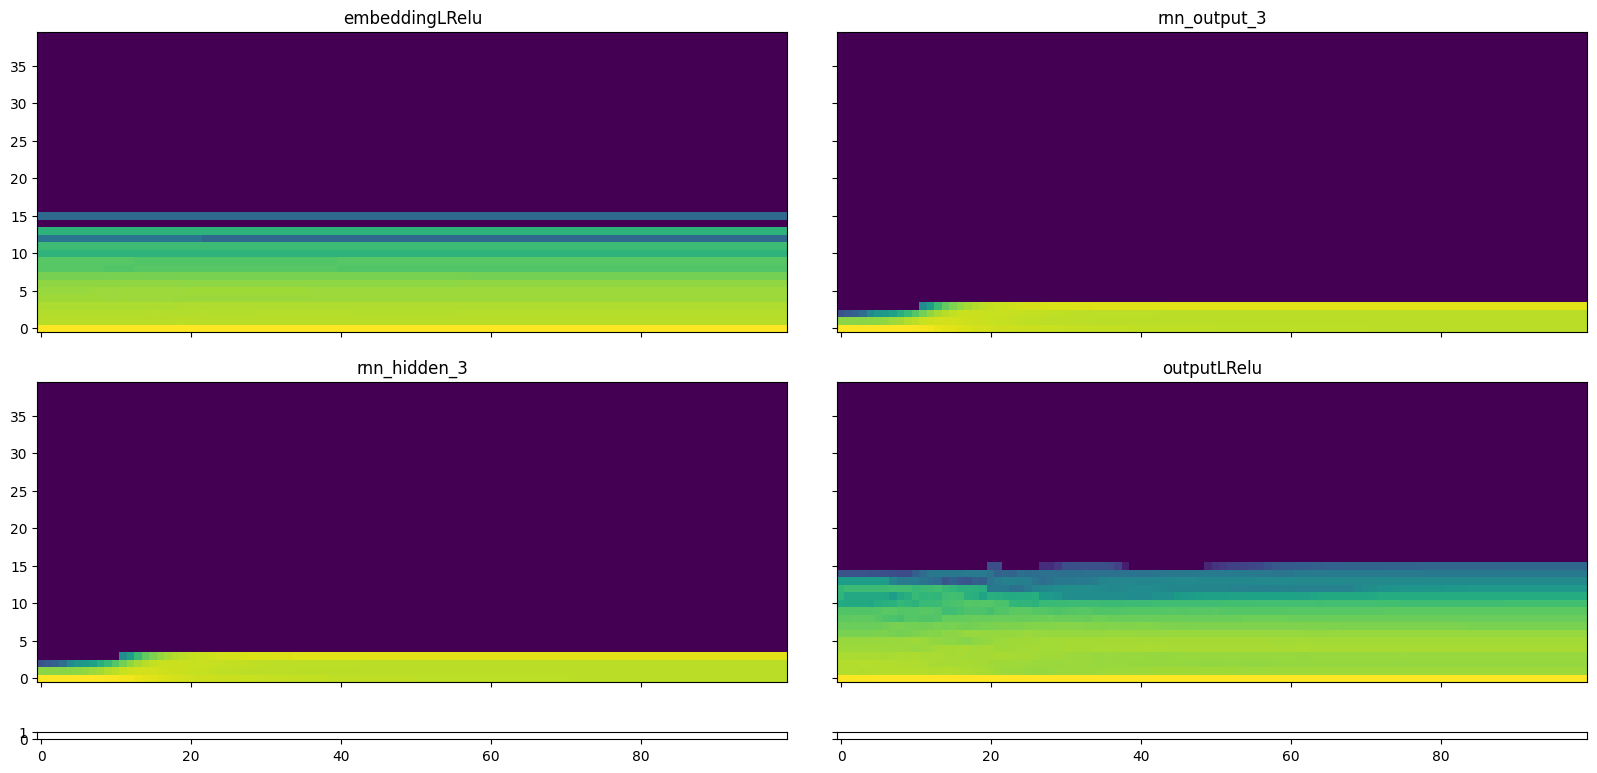

In [68]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_output.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_output[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

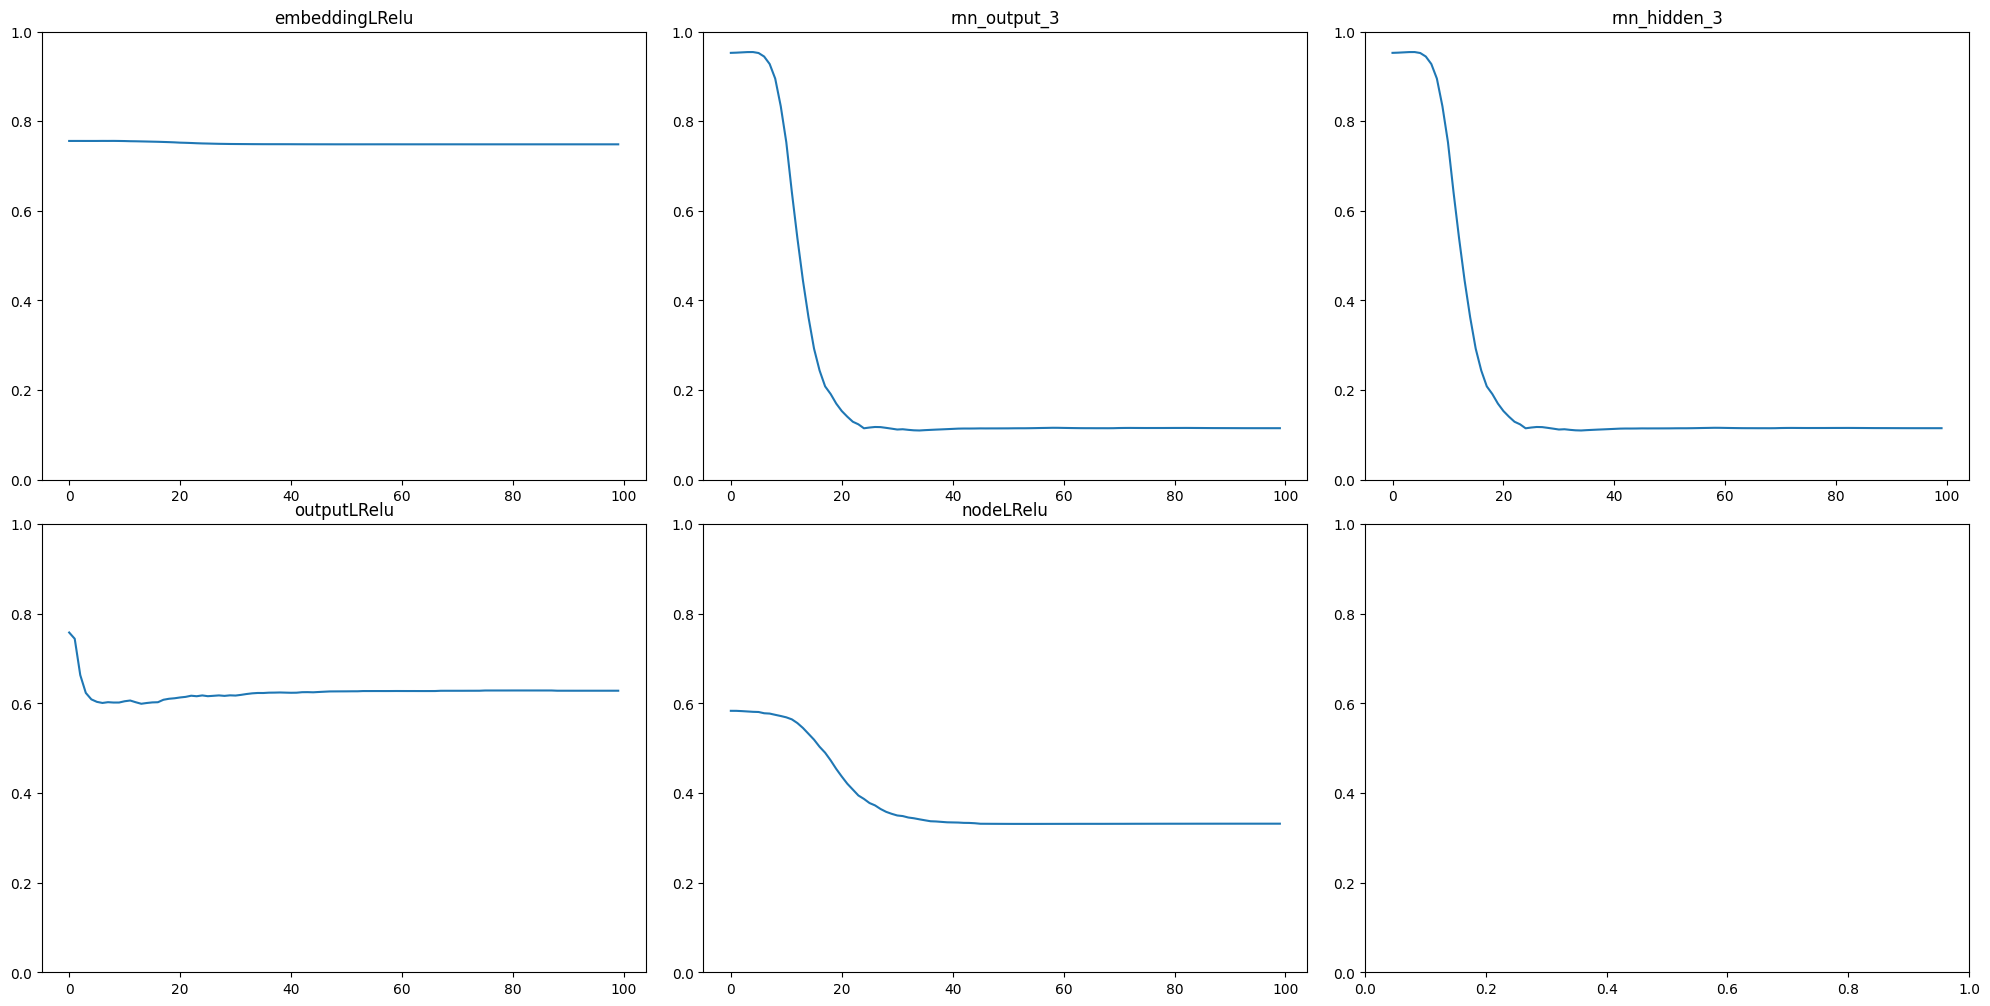

In [69]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(2,3, figsize=(20, 10))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_rnn.keys())):
    h = layer_hists_rnn[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)

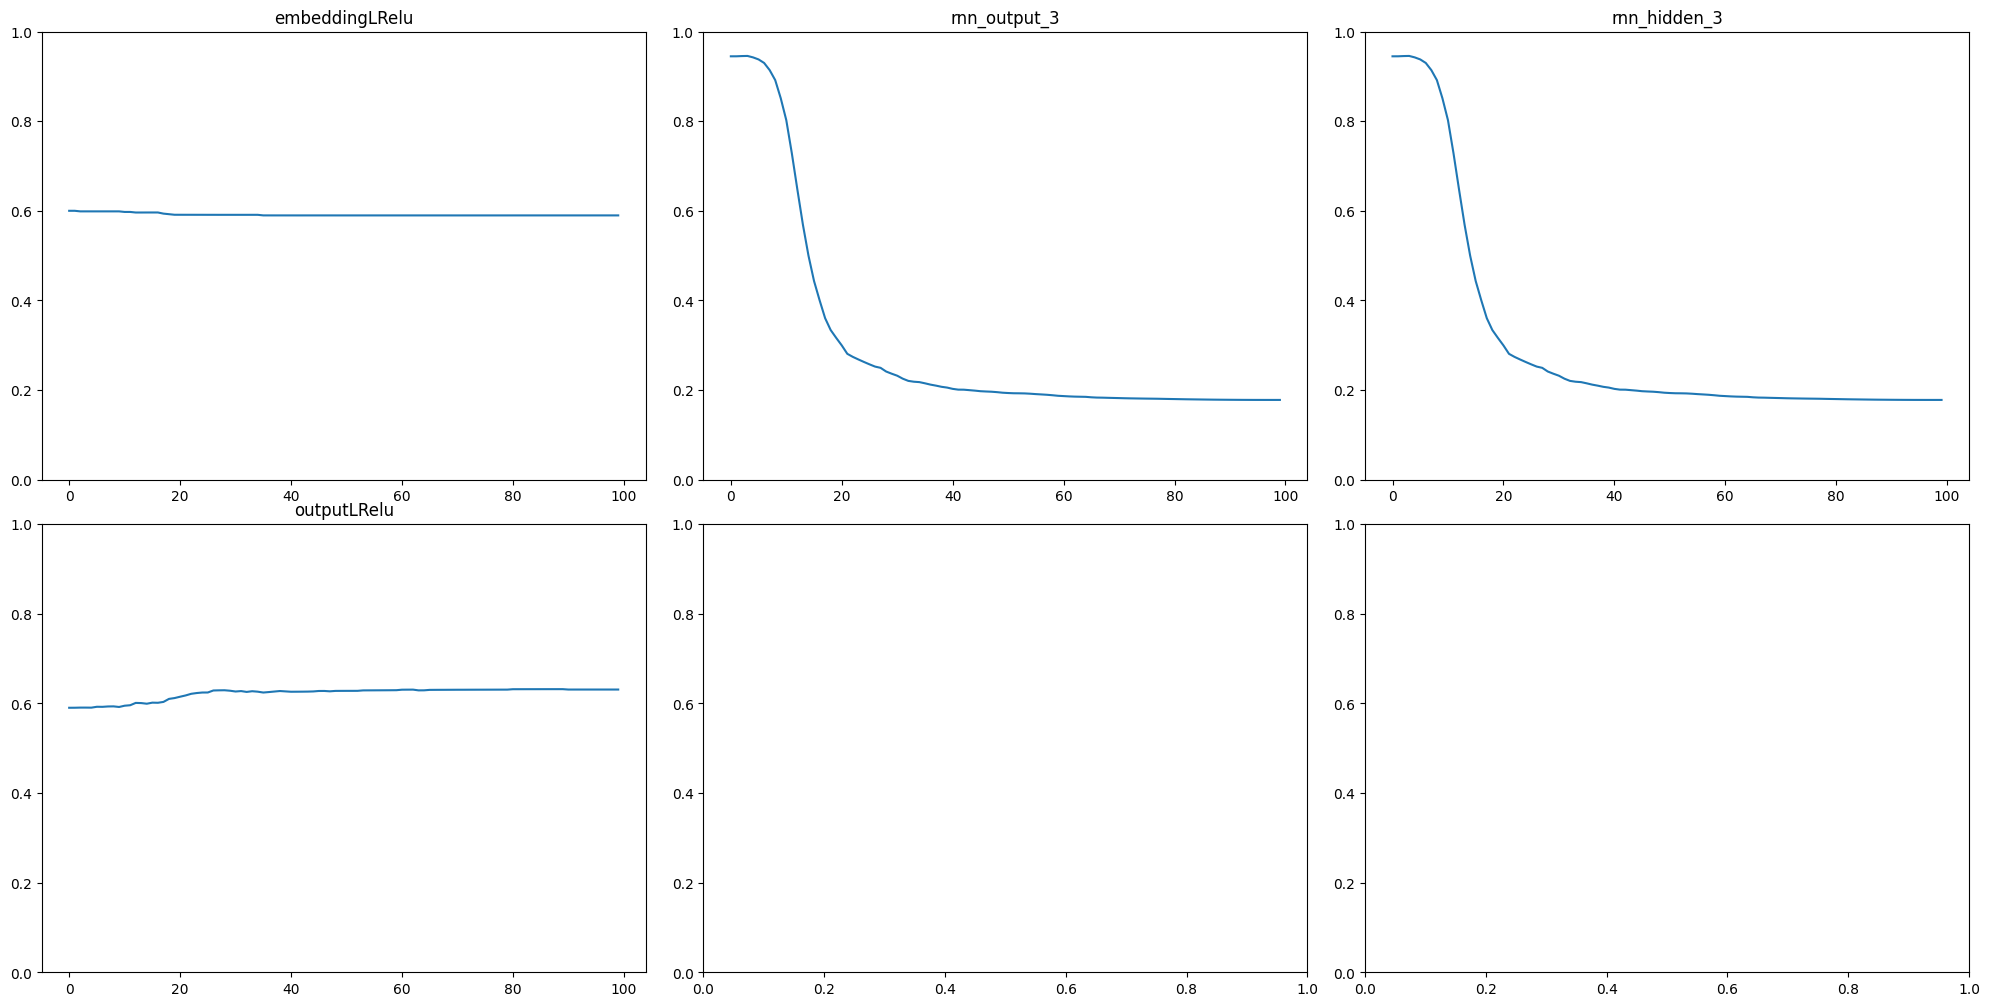

In [70]:
fig, axes = plt.subplots(2,3, figsize=(20, 10))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_output.keys())):
    h = layer_hists_output[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)

# GRADIENTS

Text(0.5, 1.0, 'nodelvl')

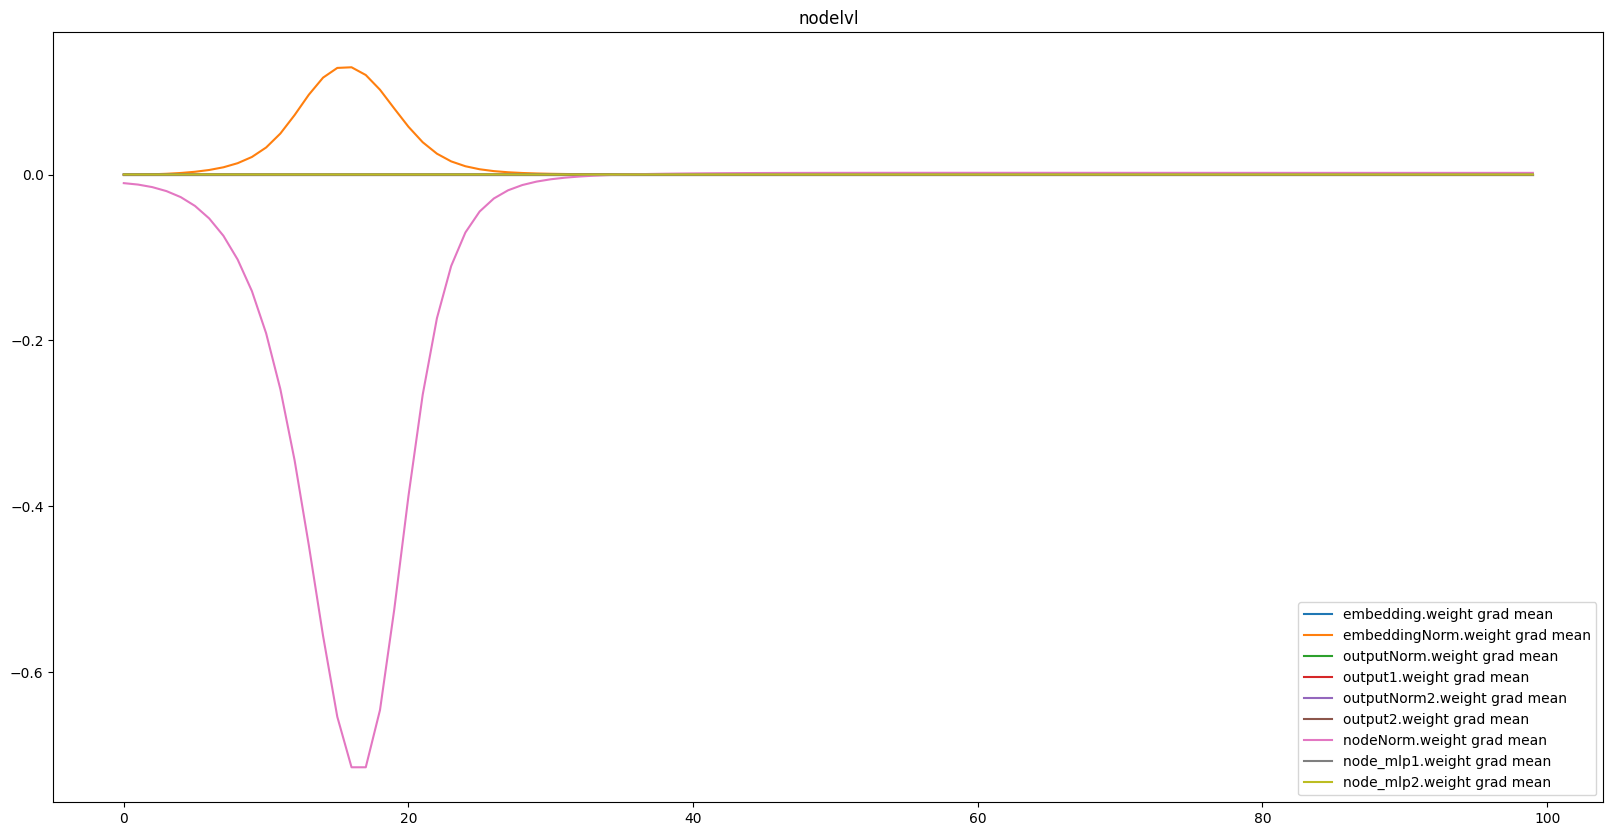

In [71]:
plt.figure(figsize=(20,10))
for color, k in enumerate(grads_dict.keys()):
    if "weight_" in k: continue
    l = grads_dict[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.mean().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')
plt.title("nodelvl")

Text(0.5, 1.0, 'edgelvl')

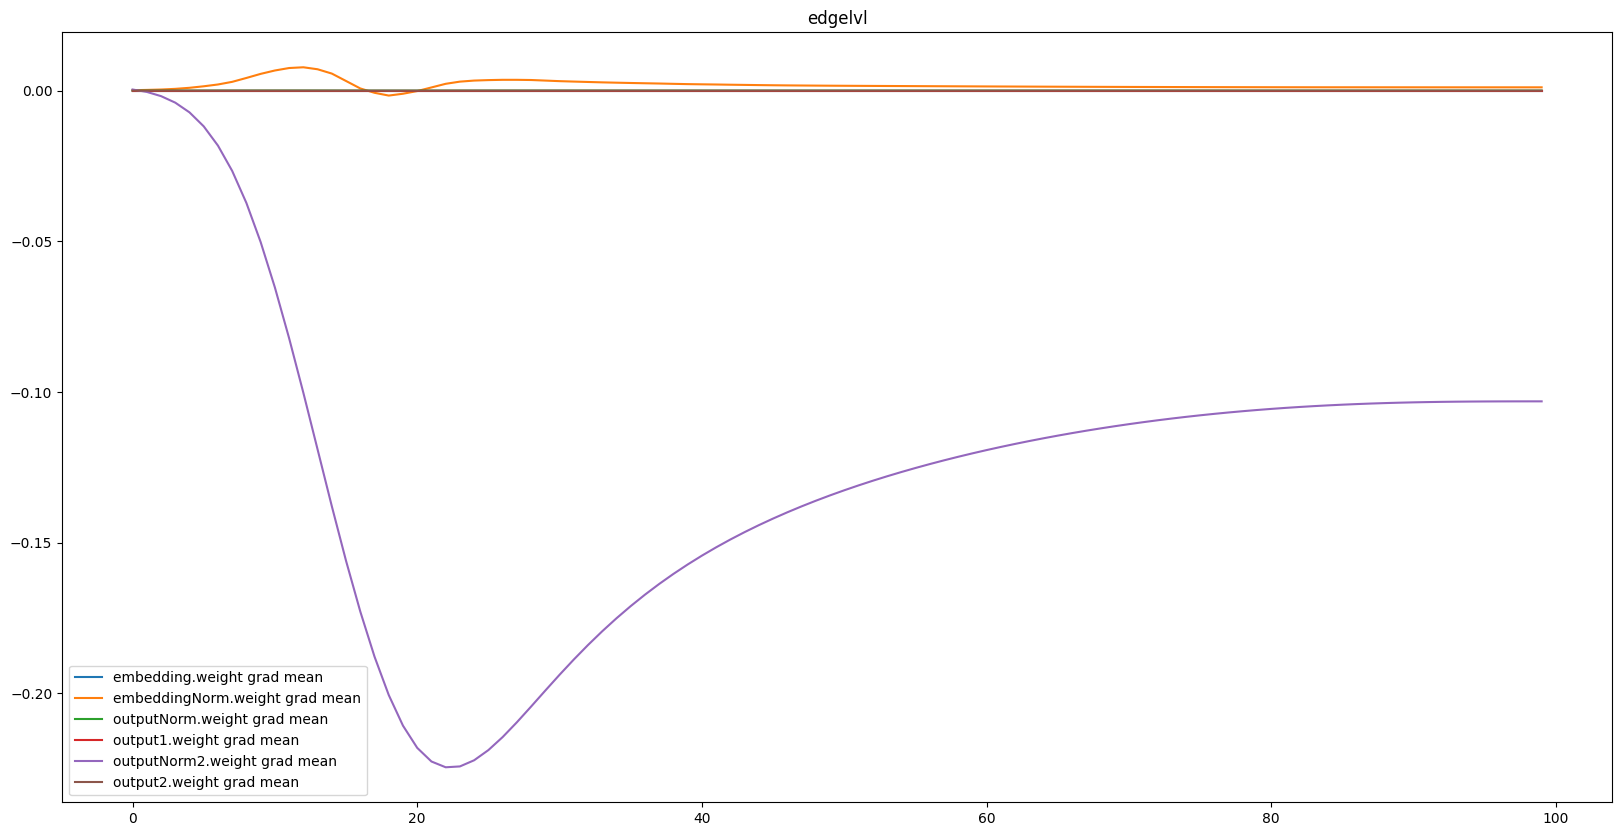

In [72]:
plt.figure(figsize=(20,10))
for color, k in enumerate(grads_dict_out.keys()):
    if "weight_" in k: continue
    l = grads_dict_out[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.mean().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')
plt.title("edgelvl")

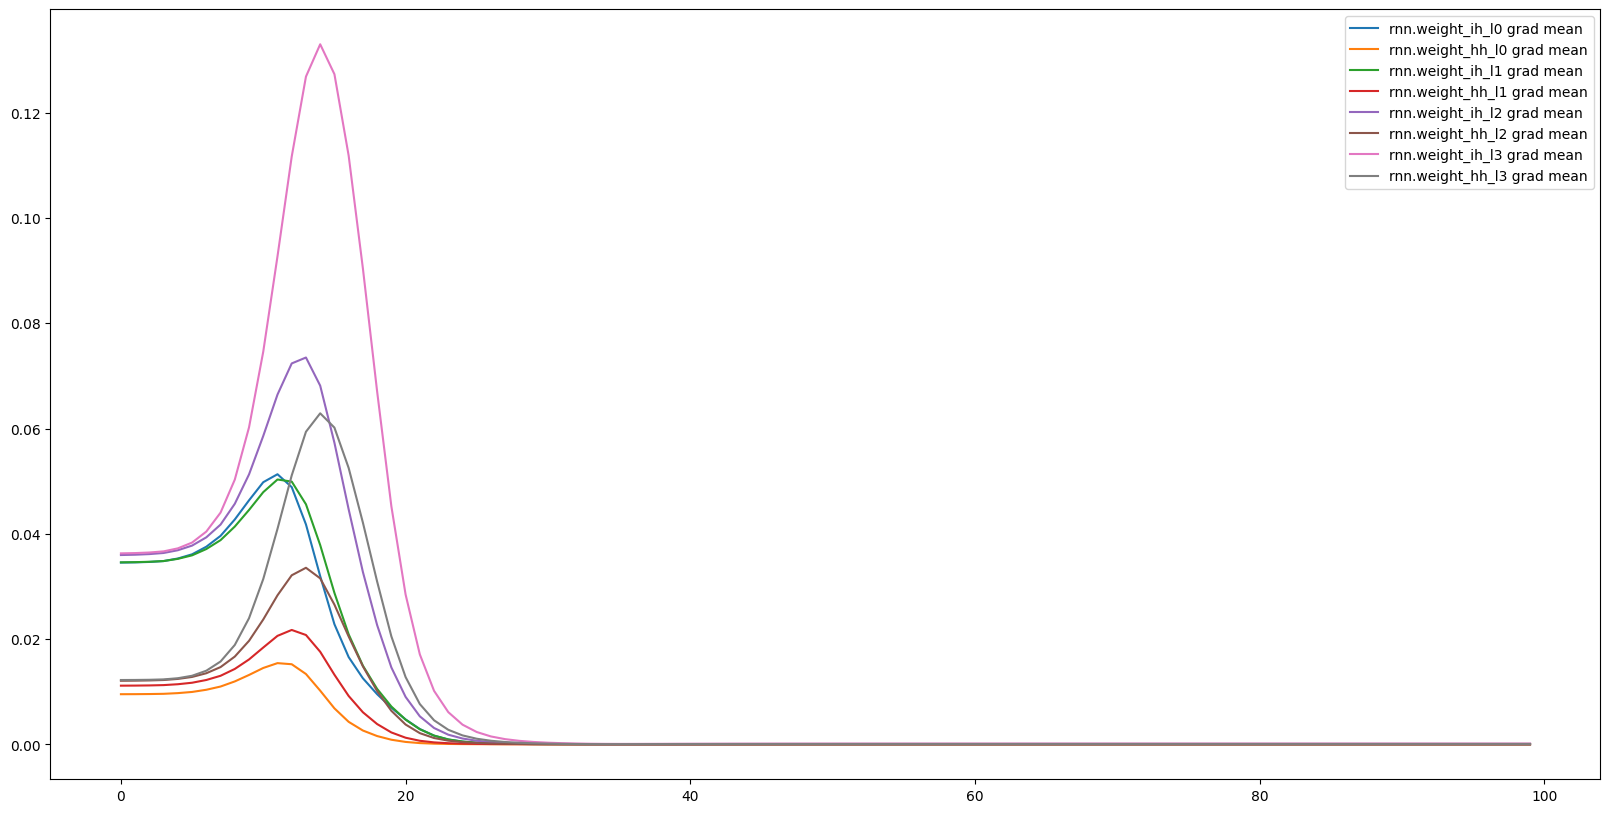

In [73]:
plt.figure(figsize=(20,10))
for color, k in enumerate(grads_dict.keys()):
    if "weight_" in k:
        l = grads_dict[k]
        r = range(len(l))
        plt.plot([i for i in r], [l[step].data.std().cpu() for step in r], label=f'{k} grad mean'.format(k=color))
plt.legend(loc='best')

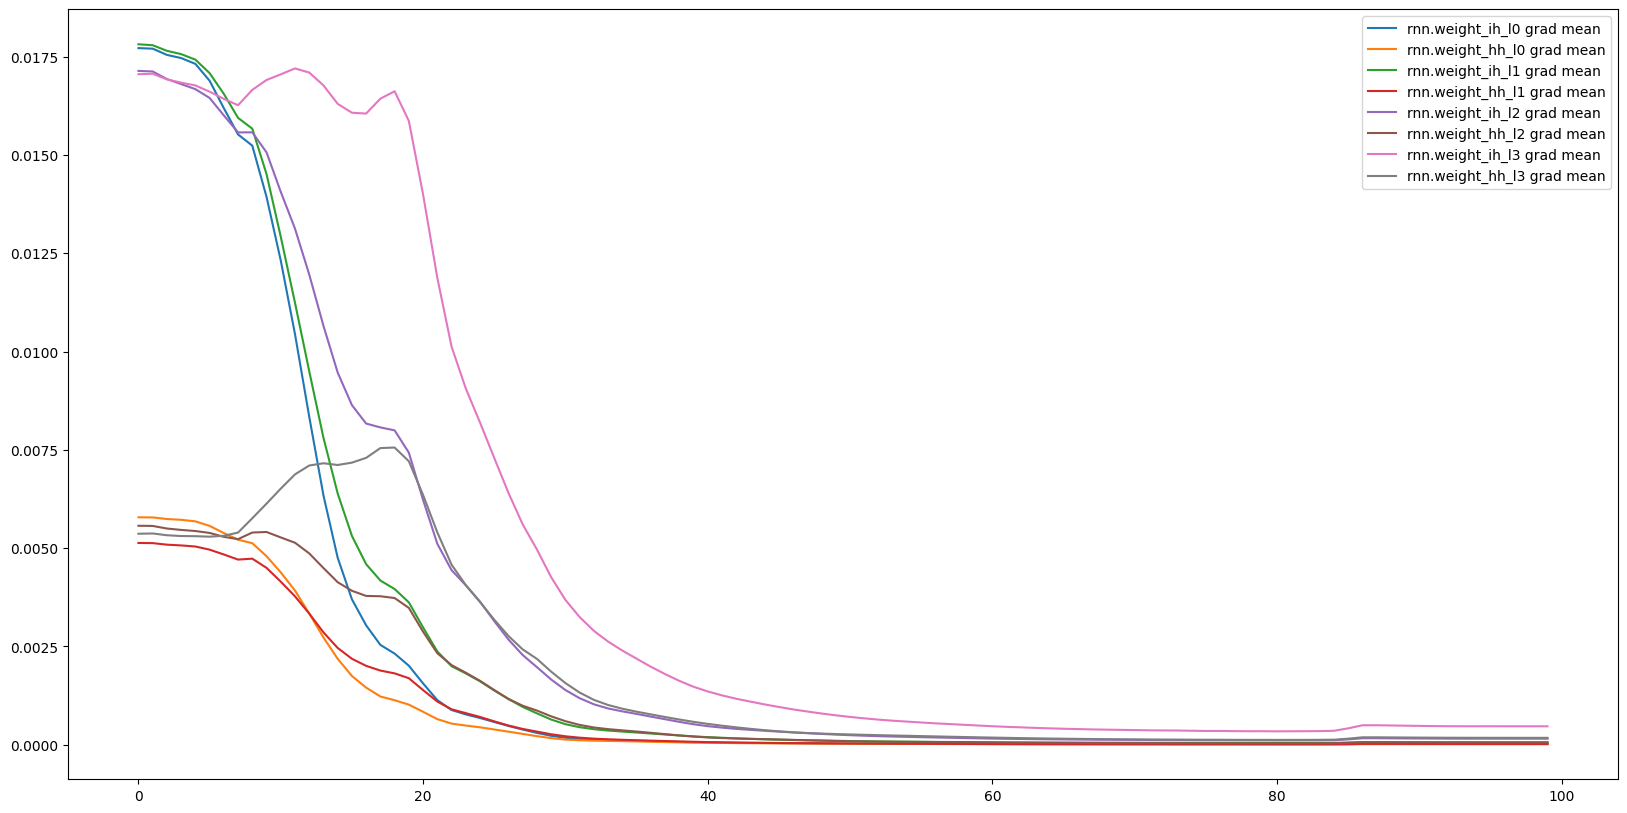

In [74]:
plt.figure(figsize=(20,10))
for color, k in enumerate(grads_dict_out.keys()):
    if "weight_" in k:
        l = grads_dict_out[k]
        r = range(len(l))
        plt.plot([i for i in r], [l[step].data.std().cpu() for step in r], label=f'{k} grad mean'.format(k=color))
plt.legend(loc='best')

Text(0.5, 1.0, 'weights and Gradients distribution')

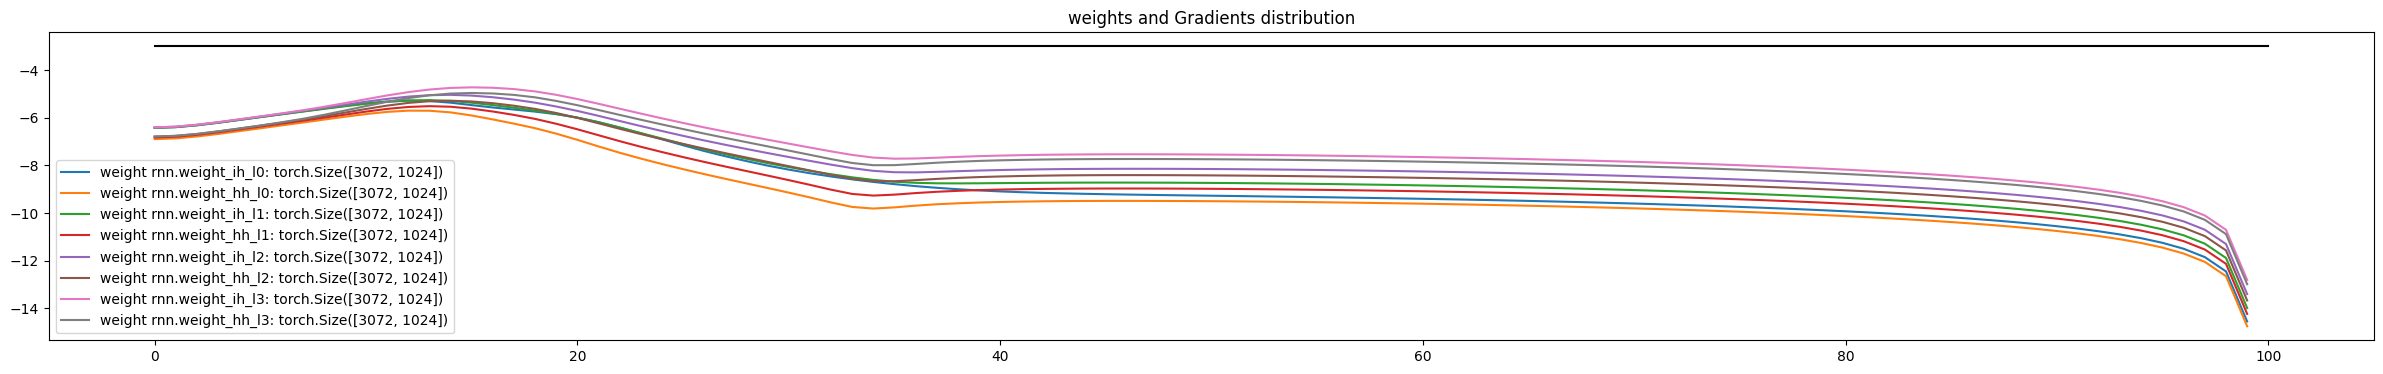

In [75]:
plt.figure(figsize=(30, 4))
legends = []
for i, (name, p) in enumerate(rnn.named_parameters()):
    if "weight_" in name:
        if p.ndim == 2:
            plt.plot([update[j][i] for j in range(len(update))])
            legends.append(f'weight {name}: {p.shape}')
plt.plot([0, len(update)], [-3, -3], 'k') # guide/target ~ 1e-3
plt.legend(legends)
plt.title('weights and Gradients distribution')

Text(0.5, 1.0, 'weights and Gradients distribution')

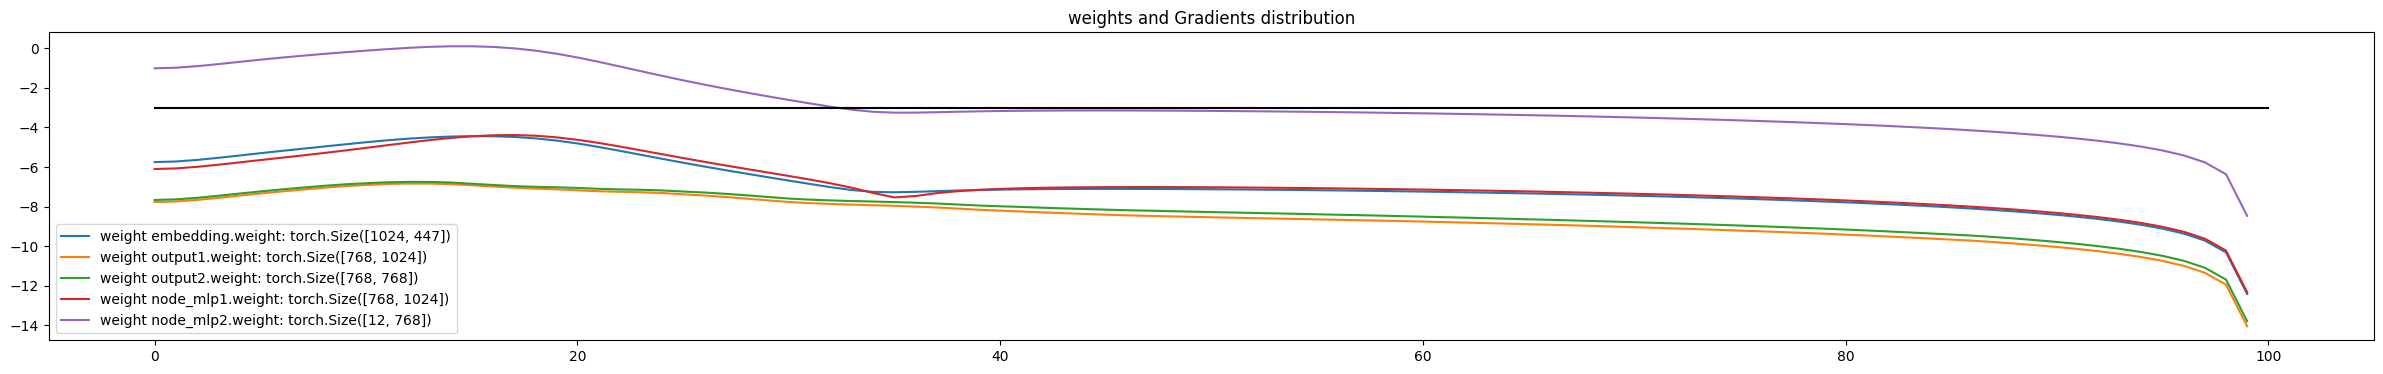

In [76]:
plt.figure(figsize=(30, 4))
legends = []
for i, (name, p) in enumerate(rnn.named_parameters()):
    if "weight_" in name: continue
    if p.ndim == 2:
        plt.plot([update[j][i] for j in range(len(update))])
        legends.append(f'weight {name}: {p.shape}')
plt.plot([0, len(update)], [-3, -3], 'k') # guide/target ~ 1e-3
plt.legend(legends)
plt.title('weights and Gradients distribution')

Text(0.5, 1.0, 'weights and Gradients distribution')

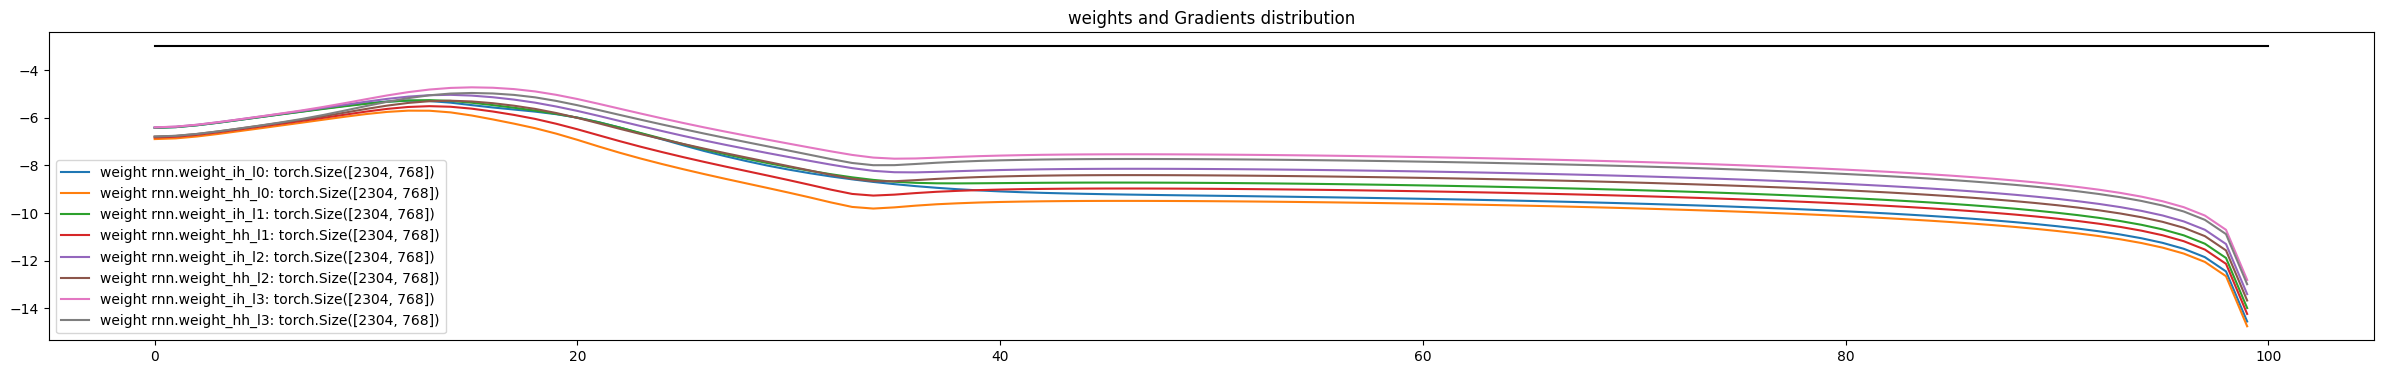

In [77]:
plt.figure(figsize=(30, 4))
legends = []
for i, (name, p) in enumerate(output.named_parameters()):
    if "weight_" in name: 
        if p.ndim == 2:
            plt.plot([update_output[j][i] for j in range(len(update))])
            legends.append(f'weight {name}: {p.shape}')
plt.plot([0, len(update_output)], [-3, -3], 'k') # guide/target ~ 1e-3
plt.legend(legends)
plt.title('weights and Gradients distribution')

Text(0.5, 1.0, 'weights and Gradients distribution')

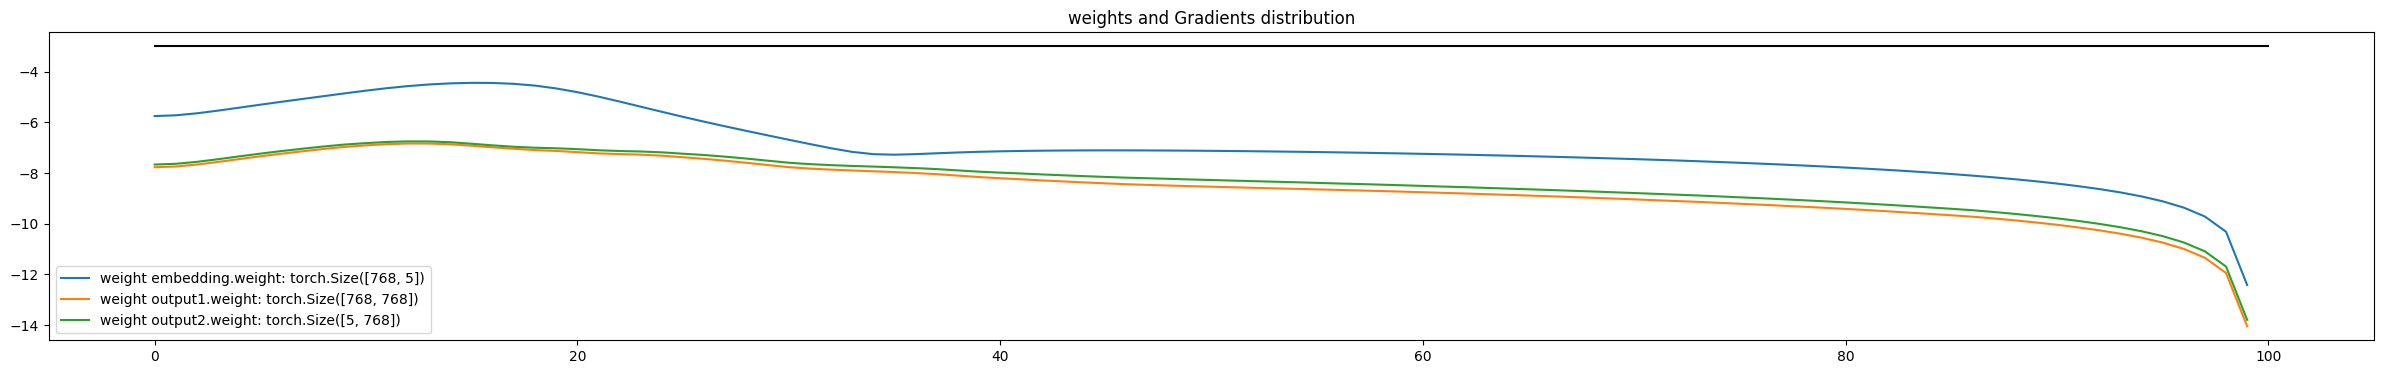

In [78]:
plt.figure(figsize=(30, 4))
legends = []
for i, (name, p) in enumerate(output.named_parameters()):
    if "weight_" in name: continue
    if p.ndim == 2:
        plt.plot([update_output[j][i] for j in range(len(update))])
        legends.append(f'weight {name}: {p.shape}')
plt.plot([0, len(update_output)], [-3, -3], 'k') # guide/target ~ 1e-3
plt.legend(legends)
plt.title('weights and Gradients distribution')

In [79]:
# so theoretically we are not updating fast enough

# FASTAI lr finder

In [23]:
shuffle(train_guac_mols)
train_data = rdkit2pyg(train_guac_mols[:32])
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS

rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=1e-6, weight_decay=10e-6, eps=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)

In [24]:
lrs, losses_lr = [], []
min_loss = math.inf
epoch = 0

while True:
    rnn.train()
    output.train()
    loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
    for batch_idx, data in enumerate(train_dataset_loader):
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        losses_lr.append(loss.item())
        if scheduler != None: current_lr = scheduler.get_last_lr()[0]
        else: current_lr = optimizer.param_groups[0]['lr']
        # nn.utils.clip_grad_value_(list(rnn.parameters()) + list(output.parameters()), clip_value=.25)
        optimizer.step()    
        lrs.append(current_lr)    
        if loss < min_loss: min_loss = loss
        if loss > 3 * min_loss: assert False
        if scheduler != None: scheduler.step()
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss_all / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    epoch +=1


Epoch 0,  tensor(3145.5657, device='cuda:0') lossedges tensor(1283.9519, device='cuda:0')  lossnodes  tensor(1861.6138, device='cuda:0')
Epoch 0,  tensor(3167.7500, device='cuda:0') lossedges tensor(1273.2870, device='cuda:0')  lossnodes  tensor(1894.4629, device='cuda:0')
Epoch 1,  tensor(3155.8623, device='cuda:0') lossedges tensor(1255.2877, device='cuda:0')  lossnodes  tensor(1900.5745, device='cuda:0')
Epoch 1,  tensor(3130.4988, device='cuda:0') lossedges tensor(1258.2534, device='cuda:0')  lossnodes  tensor(1872.2454, device='cuda:0')
Epoch 2,  tensor(3126.2178, device='cuda:0') lossedges tensor(1253.2142, device='cuda:0')  lossnodes  tensor(1873.0034, device='cuda:0')
Epoch 2,  tensor(3084.3040, device='cuda:0') lossedges tensor(1239.8582, device='cuda:0')  lossnodes  tensor(1844.4458, device='cuda:0')
Epoch 3,  tensor(3086.9202, device='cuda:0') lossedges tensor(1226.3655, device='cuda:0')  lossnodes  tensor(1860.5547, device='cuda:0')
Epoch 3,  tensor(3025.7590, device='cuda:

AssertionError: 

Text(0, 0.5, 'Loss')

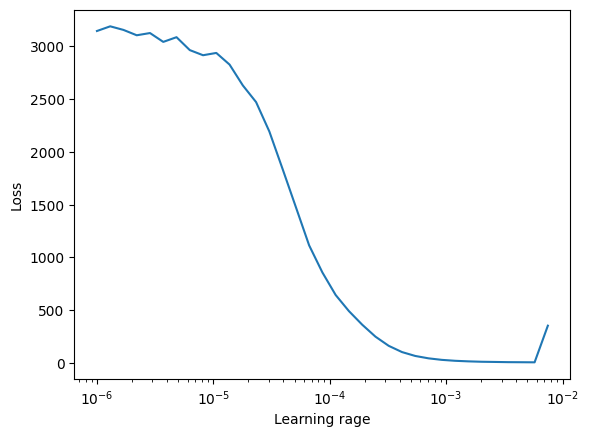

In [25]:
plt.plot(lrs, losses_lr)
plt.xscale('log')
plt.xlabel("Learning rage")
plt.ylabel("Loss")

In [ ]:
10**-4

# KARAPTHY lr finder TODO

In [ ]:
assert False

In [ ]:
max_linsp = 1000
lre = torch.linspace(-3, 0, max_linsp) # get linspace of exponents of 10**linspaced vals from [10e-3; 10e-0] = [0.001 to 1] 
lrs = 10**lre # actual lrs to be tested
# plt.plot(lrs) # we want to search between these 1000 lrs

In [ ]:
shuffle(train_guac_mols)
train_data = rdkit2pyg(train_guac_mols[:32])

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS

rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=1e-6, weight_decay=5e-4, eps=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)

In [ ]:
def update_params(params, lr):
    '''
    params: iterable containing params tensors
    lr: learning rate
    '''    
    for p in params:
        p.data += - lr * p.grad

In [ ]:
rnn.train()
output.train()
lri, lossi = [], []
for batch_idx, data in enumerate(train_dataset_loader):
    for i in range(max_linsp):
        loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        lossi.append(loss.item())
        if scheduler != None: current_lr = scheduler.get_last_lr()[0]
        else: current_lr = optimizer.param_groups[0]['lr'][0]

        # optimizer.step()    
        update_params(rnn.parameters(), lrs[i])    
        update_params(output.parameters(), lrs[i])    
        lri.append(lrs[i])    
        
        # if scheduler != None: scheduler.step()
        
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    assert False


In [ ]:
plt.plot(lri, lossi) # 10 ** -1 is good, use the one u got when overfitting a single batch


In [ ]:
index_min = np.argmin(lossi[:200])
lri[index_min]